# PS 3 - OLG

## 2.1

In [1]:
import numpy as np
import matplotlib as plt

In [40]:
#Calibration

beta_ss = 0.442
delta_ss = 0.6415
sigma_ss = 3
A_ss = 1
alpha_ss = 0.35
L_ss = 2.2

f_params_21 = (L_ss, A_ss, alpha_ss, delta_ss)
eul_args_22 = (beta_ss, sigma_ss, L_ss, A_ss, alpha_ss, delta_ss)

In [26]:
def wage_ss(args_w, bvec_guess):
    L, A, alpha = args_w
    K = bvec_guess.sum()
    w = (1-alpha)*A*(K/L)**alpha
    return w

def r_ss(args_k, bvec_guess):
    L, A, alpha, delta = args_k
    K = bvec_guess.sum()
    r = alpha*A*(L/K)**(1-alpha) - delta
    return r


In [37]:
def feasible(f_params, bvec_guess):
    
    L, A, alpha, delta = f_params
        
    #Consumption block
    
    c_cnstr = np.zeros(3)
    c_1_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[0]
    c_2_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[1] + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[0]
    c_3_ss = 0.2*wage_ss([L, A, alpha], bvec_guess) + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[1]
    c_cnstr = np.zeros((3))
    
    if c_1_ss <= 0:
        c_cnstr[0] = True
    else:
        c_cnstr[0] = False
    
    if c_2_ss <= 0:
        c_cnstr[1] = True
    else:
        c_cnstr[1] = False
    
    if c_3_ss <= 0:
        c_cnstr[2] = True
    else:
        c_cnstr[2] = False
    
    #Capital block
    
    K_cnstr = np.zeros(1)
    if bvec_guess.sum() <= 0:
        K_cnstr[0] = True
    else:
        K_cnstr[0] = False
    
    #B block
    
    b_cnstr = np.zeros(2)
    
    if c_cnstr[0] == True:
        b_cnstr[0] = True
        b_cnstr[1] = False
    
    if c_cnstr[1] == True:
        b_cnstr[0] = True
        b_cnstr[1] = True
    
    if c_cnstr[2] == True:
        b_cnstr[0] = False
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

In [38]:
bvec_guess_1 = np.array([1.0, 1.2])
output_a = feasible(f_params_21, bvec_guess_1)

bvec_guess_2 = np.array([0.06, -0.001])
output_b = feasible(f_params_21, bvec_guess_2)

bvec_guess_3 = np.array([0.1, 0.1])
output_c = feasible(f_params_21, bvec_guess_3)

print(output_a)
print(output_b)
print(output_c)

(array([1., 0.]), array([1., 0., 0.]), array([0.]))
(array([0., 0.]), array([0., 0., 0.]), array([0.]))
(array([0., 0.]), array([0., 0., 0.]), array([0.]))


## 2.2

In [57]:
def Eul_error(bvec_guess, eul_args):
    beta, sigma, L, A, alpha, delta = eul_args
    
    EulErr_ss = np.zeros(2) #intialise vector
    
    c_1_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[0]
    c_2_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[1] + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[0]
    c_3_ss = 0.2*wage_ss([L, A, alpha], bvec_guess) + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[1]
    
    if c_1_ss <= 1e-6:
        Uprime_1 = 1e8
    else:
        Uprime_1 = c_1_ss*(-sigma)
    
    if c_2_ss <= 1e-6:
        Uprime_2 = 1e8
    else:
        Uprime_2 = c_2_ss*(-sigma)
        
    if c_1_ss <= 1e-6:
        Uprime_3 = 1e8
    else:
        Uprime_3 = c_3_ss*(-sigma)

    EulErr_ss[0] = beta*(1+r_ss([L, A, alpha, delta], bvec_guess))*Uprime_2 - Uprime_1
    EulErr_ss[1] = beta*(1+r_ss([L, A, alpha, delta], bvec_guess))*Uprime_3 - Uprime_2
    
    return EulErr_ss

In [97]:
import time
import scipy.optimize as opt
from matplotlib import pyplot as plt

def get_ss(params, bvec_guess, ss_graphs):
    beta, sigma, L, A, alpha, delta, ss_tol = params
    start_time = time.clock()
    
    root =  opt.root(Eul_error, bvec_guess, [beta, sigma, L, A, alpha, delta], tol=ss_tol)
    
    #Now find all values based on roots
    
    bvec = root.x
    b_ss = bvec
    
    w_ss = wage_ss([L, A, alpha], bvec)
    rate_ss = r_ss([L, A, alpha, delta], bvec)
    
    c_ss = np.zeros(3)
    
    c_ss[0] = w_ss - bvec[0]
    c_ss[1] = w_ss - bvec[1] + (1+rate_ss)*bvec[0]
    c_ss[2] = 0.2*w_ss + (1+rate_ss)*bvec[1]
    
    K_ss = bvec.sum()
    Y_ss = A*(K_ss**alpha)*L**(1-alpha)
    C_ss = c_ss.sum()
    R_Cerr_ss = Y_ss - C_ss- delta*K_ss
    
    EulErr_ss = Eul_error(bvec, [beta, sigma, L, A, alpha, delta])
    
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('tab20b')
    if ss_graphs == True:
        plt.bar(['c_1_ss', 'c_2_ss', 'c_3_ss'], c_ss, color = palette(3))
        plt.xlabel('Cohort')
        plt.ylabel('Consumption')
        plt.show()
    
    ss_time = time.clock() - start_time
    
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'rate_ss': rate_ss,
                 'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                 'EulErr_ss': EulErr_ss, 'RCerr_ss': R_Cerr_ss,
                 'ss_time': ss_time}

    return ss_output

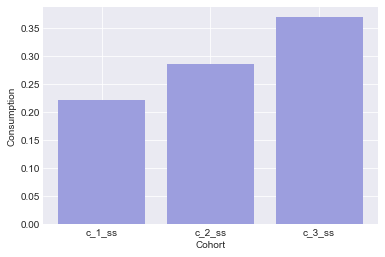

{'b_ss': array([0.08687963, 0.17505629]),
 'c_ss': array([0.22174721, 0.28598147, 0.36882257]),
 'w_ss': 0.3086268364513981,
 'rate_ss': 0.7542768853170705,
 'K_ss': 0.26193591713080294,
 'Y_ss': 1.0445831387585784,
 'C_ss': 0.8765512479191682,
 'EulErr_ss': array([-2.26580475e-07, -1.50145341e-10]),
 'RCerr_ss': 1.942890293094024e-16,
 'ss_time': 0.14361575511111369}

In [98]:
params_23 = beta_ss, sigma_ss, L_ss, A_ss, alpha_ss, delta_ss, 0.001

output = get_ss(params_23, bvec_guess_2, True)
output